In [1]:
from PIL import Image
import os
import numpy as np
import time
from scipy.io import loadmat 
from matplotlib import pyplot as plt
import cv2 as cv

In [2]:
def block_matching(img_clean,img_noisy):
    S = 10
    f = 3
    f2 = f**2
    nv = 16
    s = 3
    if img_clean.ndim < 3:
        img = img[:,:,np.newaxis]
        img_noisy = img_noisy[:,:,np.newaxis]
    img = np.pad(img_clean,((1,1),(1,1),(0,0)),'edge')
    img_noisy = np.pad(img_noisy,((1,1),(1,1),(0,0)),'edge')
    N = img.shape[0]-f+1
    M = img.shape[1]-f+1
    C = img.shape[2]
    r = np.arange(0,N,s)
    c = np.arange(0,M,s)
    L = N*M
    X = np.zeros((f2,L,C))
    X_noisy = np.zeros((f2,L,C))
    k = -1
    for i in range(f):
        for j in range(f):
            k = k+1
            blk = img[i:N+i,j:M+j,:]
            X[k,:,:] = blk.reshape(-1,C)
            blk1 = img_noisy[i:N+i,j:M+j,:]
            X_noisy[k,:,:] = blk1.reshape(-1,C)
    I = np.arange(L)
    I = I.reshape(N,M)
    pos_arr = np.zeros((nv,N*M,C),dtype = 'int64')
    X = X.swapaxes(0,1)
    X_noisy = X_noisy.swapaxes(0,1)
    i = 0
    block = {}
    for row in r:
        for col in c:
            index = row*M+col
            rmin = max(row-1,0)
            rmax = min(row+2,N)
            cmin = max(col-1,0)
            cmax = min(col+2,M)
            block[str(index)] = I[rmin:rmax,cmin:cmax].reshape(-1)
    for row in r:
        for col in c:
            i = i+1
            if i%10000 == 0:
                print(str(i)+'/'+str(M*N))
            off = row*M+col
            rmin = max(row-S*f,0)
            rmax = min(row+S*f+1,N)
            cmin = max(col-S*f,0)
            cmax = min(col+S*f+1,M)
            idx = I[rmin:rmax:s,cmin:cmax:s]
            idx = idx.reshape(-1)
            B = X[idx,:,:]
            v = X[off,:,:]
            dis = np.linalg.norm((B-v),axis = 1)/f2
            ind = np.argsort(dis,axis = 0)
            indc = idx[ind[:16,:]]
            pos_arr[:,block[str(off)],:] = indc[:,np.newaxis,:]
    return pos_arr.swapaxes(0,1),X,X_noisy,block

In [3]:
img_path = '002.png'
img_noisy_path = '001.png'
with open(img_path, 'rb') as f:
    img = Image.open(f)
    img = np.array(img)
with open(img_noisy_path,'rb') as f:
    img_noisy = Image.open(f)
    img_noisy = np.array(img_noisy)

In [5]:
img = img[:,:,0]
img_noisy = img_noisy[:,:,0]
N,M = img.shape
img1 = img[0:N:2,0:M:2]
img_noisy1 = img_noisy[0:N:2,0:M:2]
img2 = img[0:N:2,1:M:2]
img_noisy2 = img_noisy[0:N:2,1:M:2]
img3 = img[1:N:2,0:M:2]
img_noisy3 = img_noisy[1:N:2,0:M:2]
img4 = img[1:N:2,1:M:2]
img_noisy4 = img_noisy[1:N:2,1:M:2]

In [6]:
img1 = img1[:,:,np.newaxis]
img2 = img2[:,:,np.newaxis]
img3 = img3[:,:,np.newaxis]
img4 = img4[:,:,np.newaxis]
img_noisy1 = img_noisy1[:,:,np.newaxis]
img_noisy2 = img_noisy2[:,:,np.newaxis]
img_noisy3 = img_noisy3[:,:,np.newaxis]
img_noisy4 = img_noisy4[:,:,np.newaxis]
my_test = np.concatenate((img1,img2,img3,img4),axis = -1)
my_test_noisy = np.concatenate((img_noisy1,img_noisy2,img_noisy3,img_noisy4),axis = -1)

In [7]:
pos_arr,X,X_noisy,block= block_matching(my_test,my_test_noisy)

In [8]:
noisy = (X_noisy-X)/255
H,W,C= my_test.shape
block_noisy_std = np.zeros((H*W,C))
block_noisy_mean = np.zeros((H*W,C))
for key,value in block.items():
    for i in range(C): 
        block_noisy_std[value,i] = np.std(noisy[pos_arr[int(key),:,i],:,i])
        block_noisy_mean[value,i] = np.mean(noisy[pos_arr[int(key),:,i],:,i])
block_noisy_std = block_noisy_std.reshape(H,W,C)
block_noisy_mean = block_noisy_mean.reshape(H,W,C)
new_img = my_test/255 + np.random.normal(block_noisy_mean,block_noisy_std,block_noisy_std.shape)
if new_img.min() < 0:
    low_clip = 0.0
else:
    low_clip = new_img.min()
if new_img.max() >1:
    high_clip = 1.0
else: 
    high_clip = new_img.max()
new_img = np.clip(new_img, low_clip, high_clip)
new_img = np.uint8(new_img*255)

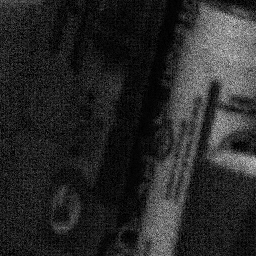

In [17]:
new_img1 = Image.fromarray(new_img[:,:,1].astype('uint8'))
new_img1

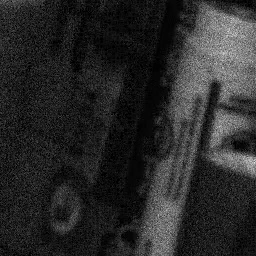

In [18]:
test1 = Image.fromarray(my_test_noisy[:,:,1].astype('uint8'))
test1

In [11]:
#new_img = np.array(new_img)
img_test1 = new_img
img_test2 = my_test_noisy
img_test2 = img_test2
img_test = np.concatenate((img_test1,img_test2),axis = -1)

In [12]:
def image_hist(image,img_path): #画三通道图像的直方图
    color = ("blue", "green",'black','red','yellow','pink','gray','orange')
    #画笔颜色的值可以为大写或小写或只写首字母或大小写混合
    for i, color in enumerate(color):
        hist = cv.calcHist([image], [i], None, [256], [0, 256])
        plt.plot(hist, color=color)
        plt.xlim([0, 256])
    plt.savefig(img_path)
    plt.show()

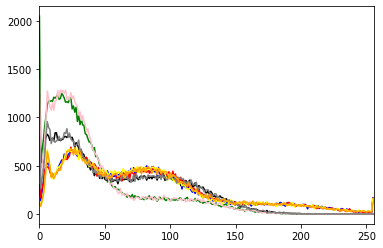

In [13]:
img_dis_path = 'gener_noisy_step3.png'
image_hist(img_test,img_dis_path)

In [14]:
#new_img = np.array(new_img)
new_img = new_img.astype('int8')
my_test_noisy = my_test_noisy.astype('int8')
my_test = my_test.astype('int8')
noisy_gener = new_img - my_test
noisy_true = my_test_noisy - my_test

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


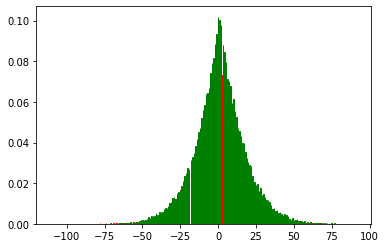

In [15]:
plt.figure("noisy_distribution1")
noisy_gener1 = noisy_gener[:,:,3].flatten()
plt.hist(noisy_gener1, bins=512, normed=1,facecolor='r',edgecolor='r')
noisy_true1 = noisy_true[:,:,3].flatten()
plt.hist(noisy_true1, bins=512, normed=1, facecolor='g',edgecolor='g')
noisy_dis_path = 'noisy_dis_step3.png'
plt.savefig(noisy_dis_path)
plt.show()

In [ ]:
def merge(new_img,block_noisy_std,block_noisy_mean,shape):
    H,W = shape
    img = np.zeros((H,W))
    img[0:H:2,0:W:2] = new_img[:,:,0]
    img[0:H:2,1:W:2] = new_img[:,:,1]
    img[1:H:2,0:W:2] = new_img[:,:,2]
    img[1:H:2,1:W:2] = new_img[:,:,3]
    noisy_std = np.zeros((H,W))
    noisy_mean = np.zeros((H,W))
    noisy_std[0:H:2,0:W:2] = block_noisy_std[:,:,0]
    noisy_std[0:H:2,1:W:2] = block_noisy_std[:,:,1]
    noisy_std[1:H:2,0:W:2] = block_noisy_std[:,:,2]
    noisy_std[1:H:2,1:W:2] = block_noisy_std[:,:,3]
    noisy_mean[0:H:2,0:W:2] = block_noisy_mean[:,:,0]
    noisy_mean[0:H:2,1:W:2] = block_noisy_mean[:,:,1]
    noisy_mean[1:H:2,0:W:2] = block_noisy_mean[:,:,2]
    noisy_mean[1:H:2,1:W:2] = block_noisy_mean[:,:,3]
    return img,noisy_std,noisy_mean

In [16]:
new_img.shape

(256, 256, 4)

In [20]:
img_fan = np.zeros((N,M))

In [21]:
img_fan.shape

(512, 512)

In [22]:
img_fan[0:N:2,0:M:2] = new_img[:,:,0]

In [25]:
img_fan[0:N:2,1:M:2] = new_img[:,:,1]

In [27]:
img_fan[1:N:2,0:M:2] = new_img[:,:,2]

In [30]:
img_fan[1:N:2,1:M:2] = new_img[:,:,3]

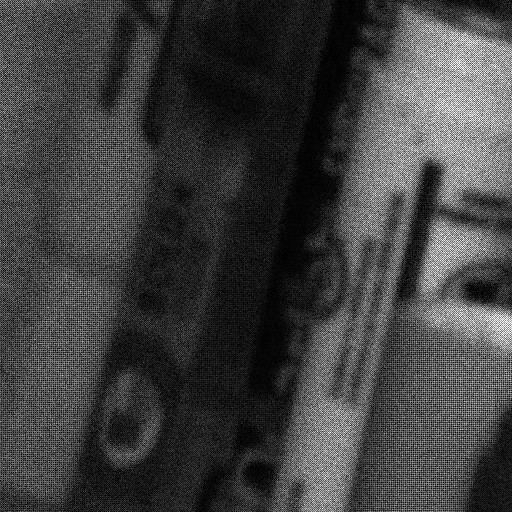

In [31]:
new_img1 = Image.fromarray(img_fan.astype('uint8'))
new_img1

In [33]:
new_img1.save('./test.png')